# Bank Institution Term Deposit Predictive Model

- [Data Analysis](#Data-Analysis)
    - [Missing Values](#Missing-Values)
    - [Univariate Analysis](#Univariate-Analysis)
    - [Multivariate Analysis](#Multivariate-Analysis)
        - [Confusion matrix](#Confusion-matrix)
- [Preprocessing](#Preprocessing)
    - [T-Distributed Stochastic Neighbouring Entities (TSNE)](#T-Distributed-Stochastic-Neighbouring-Entities-(TSNE))
    - [PCA](#PCA)
- [Machine Learning Model](#Machine-Learning-Model)
    - [Model with Outliers](#Model-with-Outliers)
    - [Model without outliers](#Model-without-outliers)
    - [Validation Set](#Validation-Set)

In [1]:
# logging 
import logging

# data handling
import pandas as pd
import numpy as np
from statistics import mean

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing modules
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Y LabelEncoder
from sklearn.preprocessing import LabelEncoder

# splitting the datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# models 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# metrics
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve

In [159]:
df = pd.read_csv('../bank-additional-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Analysis

### Missing Values

from the data description the cells with "unknown" value are Nan values and are found in the categorical colums, Lets convert this cells to NaN Values to ease our Analysis problem

In [3]:
df = df.replace('unknown', np.NaN)

In [4]:
# Check for null values
df.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

The columns with are unknown values in the job and marital columns are not that many we can so drop them

In [5]:
df = df[df.job.notna()]
# the shape should be less with 300
df.shape

(40858, 21)

In [6]:
df = df[df.marital.notna()]
# the shape should change
df.shape

(40787, 21)

In [8]:
# Check for null values
df.isnull().sum()

age                  0
job                  0
marital              0
education         1596
default           8436
housing            984
loan               984
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Since these columns (eduaction, default, housing and loan) are categorical columns,we have to replace the null values with random values in the column instead of using the normal mean, mode, median methods. We get a random permutation of the values in the columns and from this permutation remove the null values from it and select a random value in the new permuation(the one without null values) and replace a null value with it. 

In [10]:
# Fill in the missing values columns with random values in the column
def randomCatFill(df, colName):
    # create a random permutation of the categorical values in the col
    perm = np.random.permutation(df[colName])
    
    # erase the empty values in the permutation
    perm = perm[~pd.isnull(perm)]
    
    # replace all NaN values in the education columns
    end = len(perm)
    df[colName] = df[colName].apply(lambda x: perm[np.random.randint(end)] if pd.isnull(x) else x)
    

In [11]:
# replace missing values in education col
randomCatFill(df, 'education')

# replace missing values in housing col
randomCatFill(df, 'housing')

# replace missing values in default col
randomCatFill(df, 'default')

# replace missing values in loan col
randomCatFill(df, 'loan')

In [17]:
# Check for null values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Univariate Analysis

Lets change the class balance between in the various caategorical columns to see which classes have the largest "Market Share". The best tool for this is the piechart 

In [18]:
df.job.value_counts()

admin.           10408
blue-collar       9240
technician        6731
services          3963
management        2921
retired           1715
entrepreneur      1453
self-employed     1416
housemaid         1057
unemployed        1009
student            874
Name: job, dtype: int64

([<matplotlib.patches.Wedge at 0x7f4b2c6bff98>,
 [Text(0.7650588788123293, 0.7903701107395332, 'admin.'),
  Text(-0.7451606293086133, 0.8091573620306446, 'blue-collar'),
  Text(-1.0116151390786972, -0.43201251184055833, 'technician'),
  Text(-0.3704529943607538, -1.0357434909132432, 'services'),
  Text(0.2042281847139887, -1.0808750383686494, 'management'),
  Text(0.5691594015782021, -0.9413063133726147, 'retired'),
  Text(0.7797172717985724, -0.7759129951605344, 'entrepreneur'),
  Text(0.9308278590261242, -0.5861394858400532, 'self-employed'),
  Text(1.0249668385498267, -0.3993031177854407, 'housemaid'),
  Text(1.0752907285879953, -0.23184013675957452, 'unemployed'),
  Text(1.0975084005188536, -0.07399534303283956, 'student')])

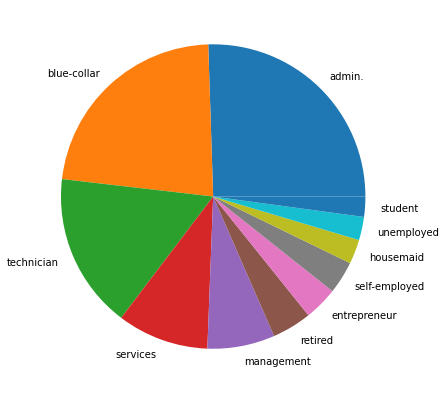

In [19]:
# get the column names in the way they are ranked by number of values
labels = df.job.value_counts().index.tolist()

# plot the job pie chart.
plt.figure(figsize=(7,7))
plt.pie(df.job.value_counts(),labels=labels)

([<matplotlib.patches.Wedge at 0x7f1608bf4518>,
 [Text(-0.35774081574418765, 1.0402026286982182, 'married'),
  Text(-0.025288783837156995, -1.0997092694944595, 'single'),
  Text(1.0317033026806188, -0.38156034285274437, 'divorced')])

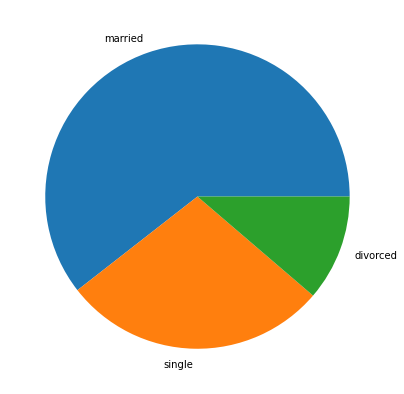

In [16]:
# get the column names in the way they are ranked by number of values
labels = df.marital.value_counts().index.tolist()

# plot the pie chart
plt.figure(figsize=(7,7))
plt.pie(df.marital.value_counts(),labels=labels)

In [17]:
# values in education ranked by number of values
df.education.value_counts()

university.degree      12573
high.school             9873
basic.9y                6253
professional.course     5436
basic.4y                4276
basic.6y                2356
illiterate                20
Name: education, dtype: int64

([<matplotlib.patches.Wedge at 0x7f1608bc07b8>,
 [Text(0.6232557133077491, 0.9063952315790552, 'university.degree'),
  Text(-0.9932140658893067, 0.47278517248284363, 'high.school'),
  Text(-0.7680970681050785, -0.7874178649029895, 'basic.9y'),
  Text(0.13971732255451058, -1.0910907706411044, 'professional.course'),
  Text(0.8445941891178989, -0.7047415524206582, 'basic.4y'),
  Text(1.0813207452190314, -0.20185501222154115, 'basic.6y'),
  Text(1.099998694792784, -0.0016945365654873214, 'illiterate')])

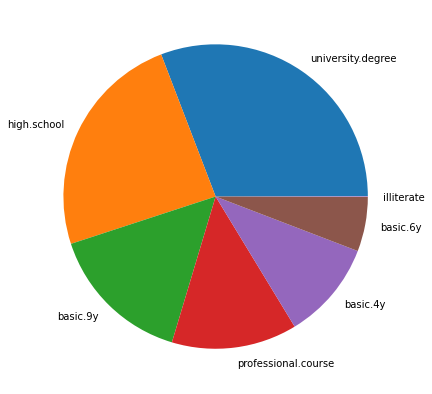

In [18]:
# plots the education pie chart
labels = df.education.value_counts().index.tolist()
plt.figure(figsize=(7,7))

plt.pie(df.education.value_counts(),labels=labels)

In [19]:
# values in default ranked by number of values
df.default.value_counts()

no     40784
yes        3
Name: default, dtype: int64

([<matplotlib.patches.Wedge at 0x7f1608ba8198>,
 [Text(-1.099999970633448, 0.0002541779178404444, 'no'),
  Text(1.0999999706340173, -0.0002541754537373679, 'yes')])

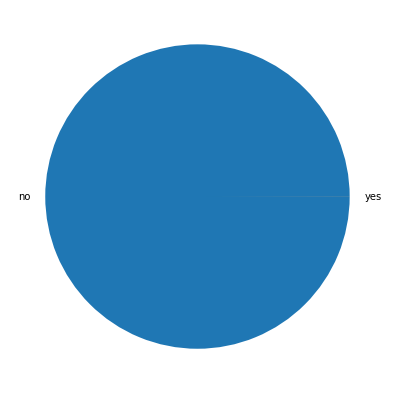

In [20]:
# get the column names in the way they are ranked by number of values
labels = df.default.value_counts().index.tolist()

# get the plot figure 
plt.figure(figsize=(7,7))
plt.pie(df.default.value_counts(),labels=labels)

In [21]:
# values in default ranked by number of values
df.housing.value_counts()

yes    21906
no     18881
Name: housing, dtype: int64

([<matplotlib.patches.Wedge at 0x7f1608b67da0>,
 [Text(-0.1278596597432495, 1.0925437782580343, 'yes'),
  Text(0.12785976203457966, -1.0925437662869442, 'no')])

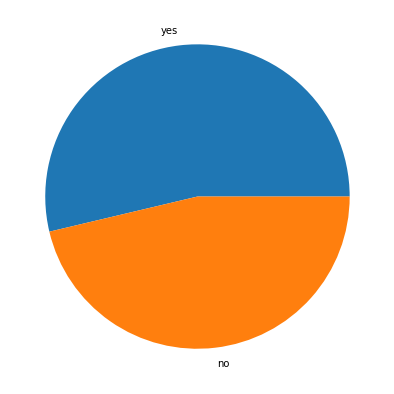

In [22]:
# get the column names in the way they are ranked by number of values
labels = df.housing.value_counts().index.tolist()

# get the plot figure 
plt.figure(figsize=(7,7))
plt.pie(df.housing.value_counts(),labels=labels)

In [23]:
# values in loan ranked by number of values
df.loan.value_counts()

no     34447
yes     6340
Name: loan, dtype: int64

([<matplotlib.patches.Wedge at 0x7f1608b7c1d0>,
 [Text(-0.9714270043842357, 0.5160712888284625, 'no'),
  Text(0.9714269802251938, -0.5160713343042425, 'yes')])

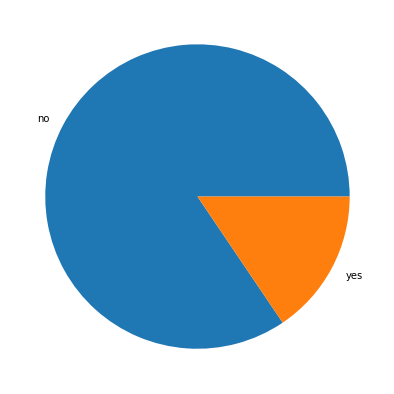

In [24]:
# get the column names in the way they are ranked by number of values
labels = df.loan.value_counts().index.tolist()

# get the plot figure 
plt.figure(figsize=(7,7))
plt.pie(df.loan.value_counts(),labels=labels)

In [25]:
# values in contact ranked by number of values
df.contact.value_counts()

cellular     25928
telephone    14859
Name: contact, dtype: int64

([<matplotlib.patches.Wedge at 0x7f1608a7c320>,
 [Text(-0.45484648668593375, 1.001556126010651, 'cellular'),
  Text(0.45484639291347956, -1.001556168596448, 'telephone')])

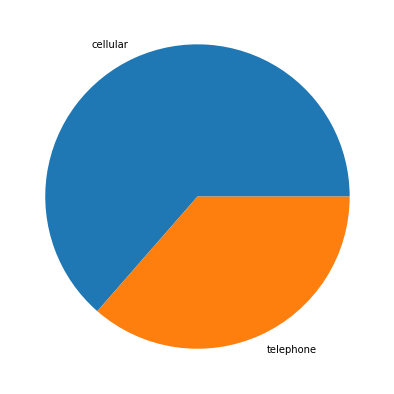

In [26]:
# get the column names in the way they are ranked by number of values
labels = df.contact.value_counts().index.tolist()

# get the plot figure 
plt.figure(figsize=(7,7))
plt.pie(df.contact.value_counts(),labels=labels)

In [27]:
# values in poutcome ranked by number of values
df.poutcome.value_counts()

nonexistent    35217
failure         4221
success         1349
Name: poutcome, dtype: int64

([<matplotlib.patches.Wedge at 0x7f1608a3ce80>,
 [Text(-1.0003086221820103, 0.4575835010009959, 'nonexistent'),
  Text(0.9474534909399374, -0.5588666052876358, 'failure'),
  Text(1.094067302249957, -0.11409092053052067, 'success')])

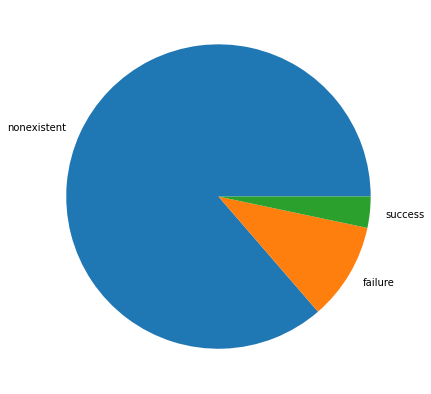

In [28]:
# get the column names in the way they are ranked by number of values
labels = df.poutcome.value_counts().index.tolist()

# get the plot figure 
plt.figure(figsize=(7,7))
plt.pie(df.poutcome.value_counts(),labels=labels)

<AxesSubplot:xlabel='month', ylabel='count'>

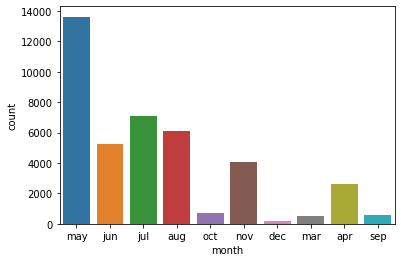

In [29]:
# This plot shows the distribution of the users reached across the different months
sns.countplot(x='month', data=df)

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

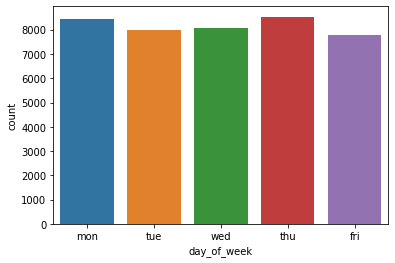

In [30]:
# This plot shows the distribution of the users reached across the different days
sns.countplot(x='day_of_week', data=df)

<AxesSubplot:xlabel='age'>

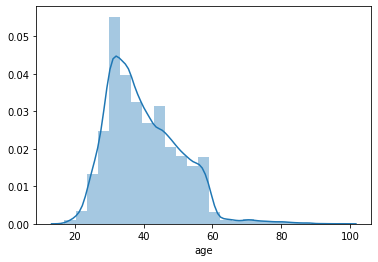

In [31]:
# plotting the distribution of the age column
sns.distplot(df.age, bins=25)

<AxesSubplot:xlabel='cons.price.idx'>

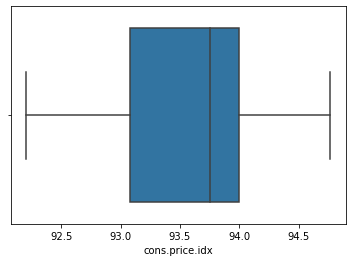

In [50]:
#plot the boxplot for the consumer price index
sns.boxplot(df['cons.price.idx'])

<AxesSubplot:xlabel='cons.conf.idx'>

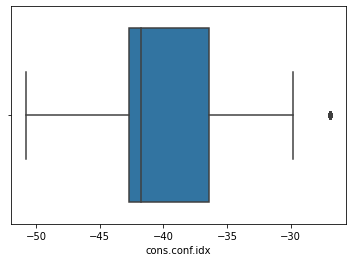

In [51]:
#plot the boxplot for the consumer confidence index
sns.boxplot(df['cons.conf.idx'])

<AxesSubplot:xlabel='emp.var.rate'>

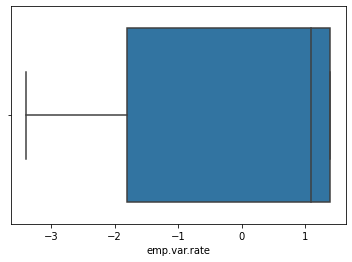

In [52]:
#plot the boxplot for the consumer price index
sns.boxplot(df['emp.var.rate'])

<AxesSubplot:xlabel='nr.employed'>

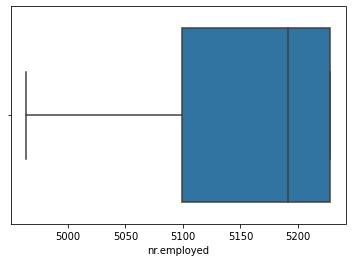

In [55]:
#plot the boxplot for the number of employed
sns.boxplot(df['nr.employed'])

## Multivariate Analysis

In [32]:
# Turns the Month column into the corresponding month number
df.month = df.month.str.capitalize()
df["month"] = pd.to_datetime(df.month, format='%b', errors='coerce').dt.month

# Sorts the dataframe by the order of months
df = df.sort_values(by="month")
df.month.unique()


array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

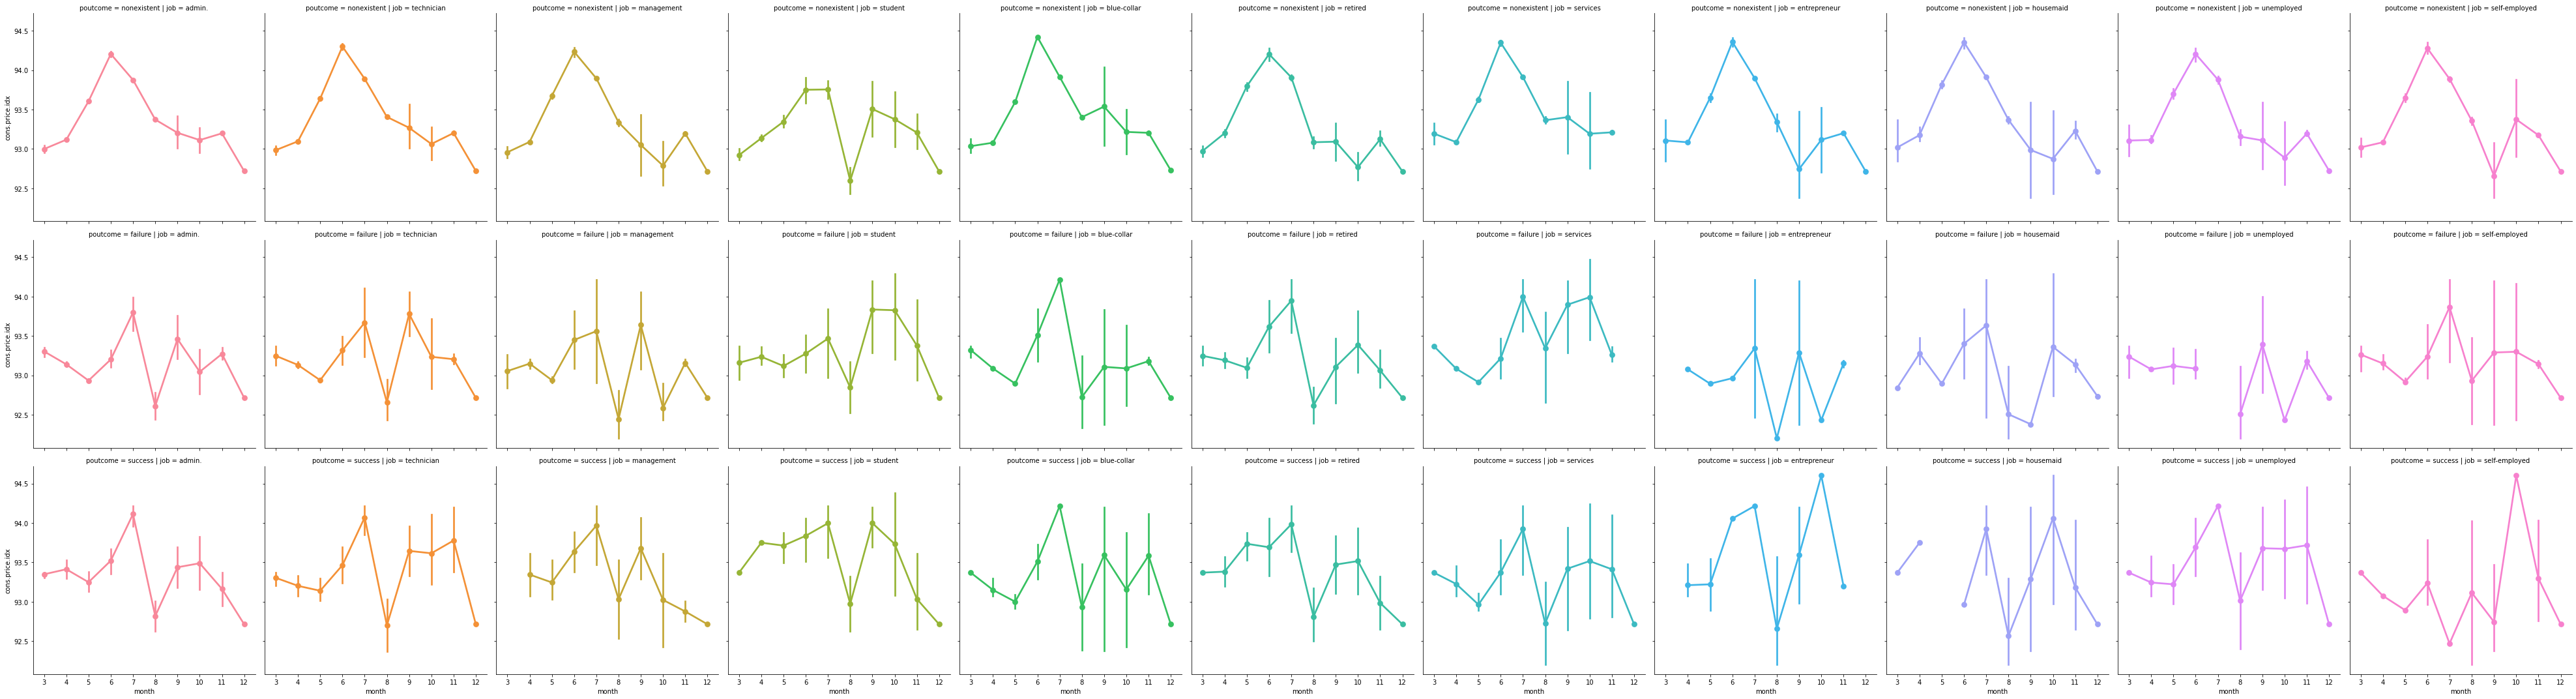

In [33]:
# Plotting the monthly consumer price index for each job group and previous outcome
sns.catplot(x='month', y='cons.price.idx', data=df, kind='point',
            col='job', row='poutcome', hue='job')

(Double Click to Zoom)
- In the month of Novemeber and December the consumer price index was not recorded for job group services where the previous outcome was nonexistent or a failure
- In the month of February the consumer price index was not recorded for job group entrepreneur where the previous outcome was a success.
- In the month of April and May the consumer price index was not recorded for job group housemaid where the previous outcome was a success.
- In the month of June and July the consumer price index was not recorded for job group unemployed where the previous outcome was a failure.

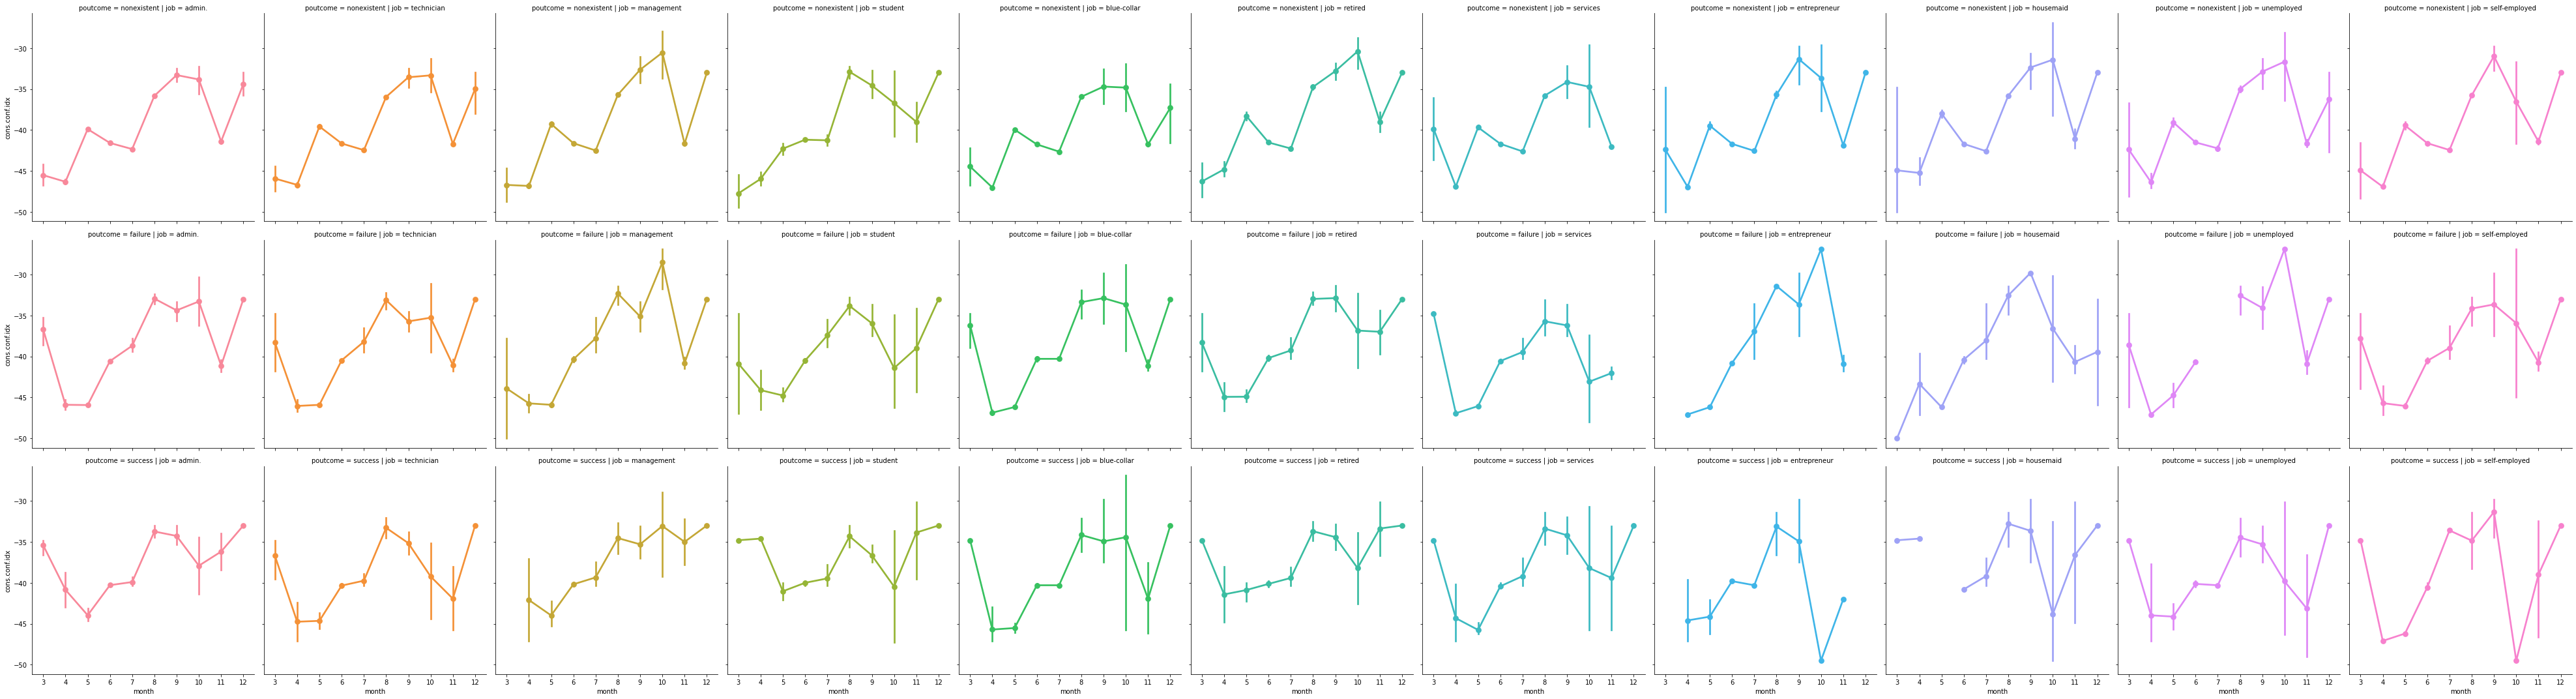

In [34]:
# Plotting the monthly consumer confidence index for each job group and previous outcome
sns.catplot(x='month', y='cons.conf.idx', data=df, kind='point',
            col='job', row='poutcome', hue='job')

(Double Click to Zoom)
- In the months of February the consumer Confidence index was not recorded for job group Management where the previous outcome was a success.
- In the months of Novemeber and December the consumer Confidence index was not recorded for job group services where the previous outcome was nonexistent or a failure.
- In the months of February and December the consumer Confidence index was not recorded for job group entrepreneur where the previous outcome was nonexistent or a failure.
- In the months of April and June the consumer Confidence index was not recorded for job group housemaid where the previous outcome was a success.
- In the months of June and July the consumer Confidence index was not recorded for job group unemployed where the previous outcome was a failure.

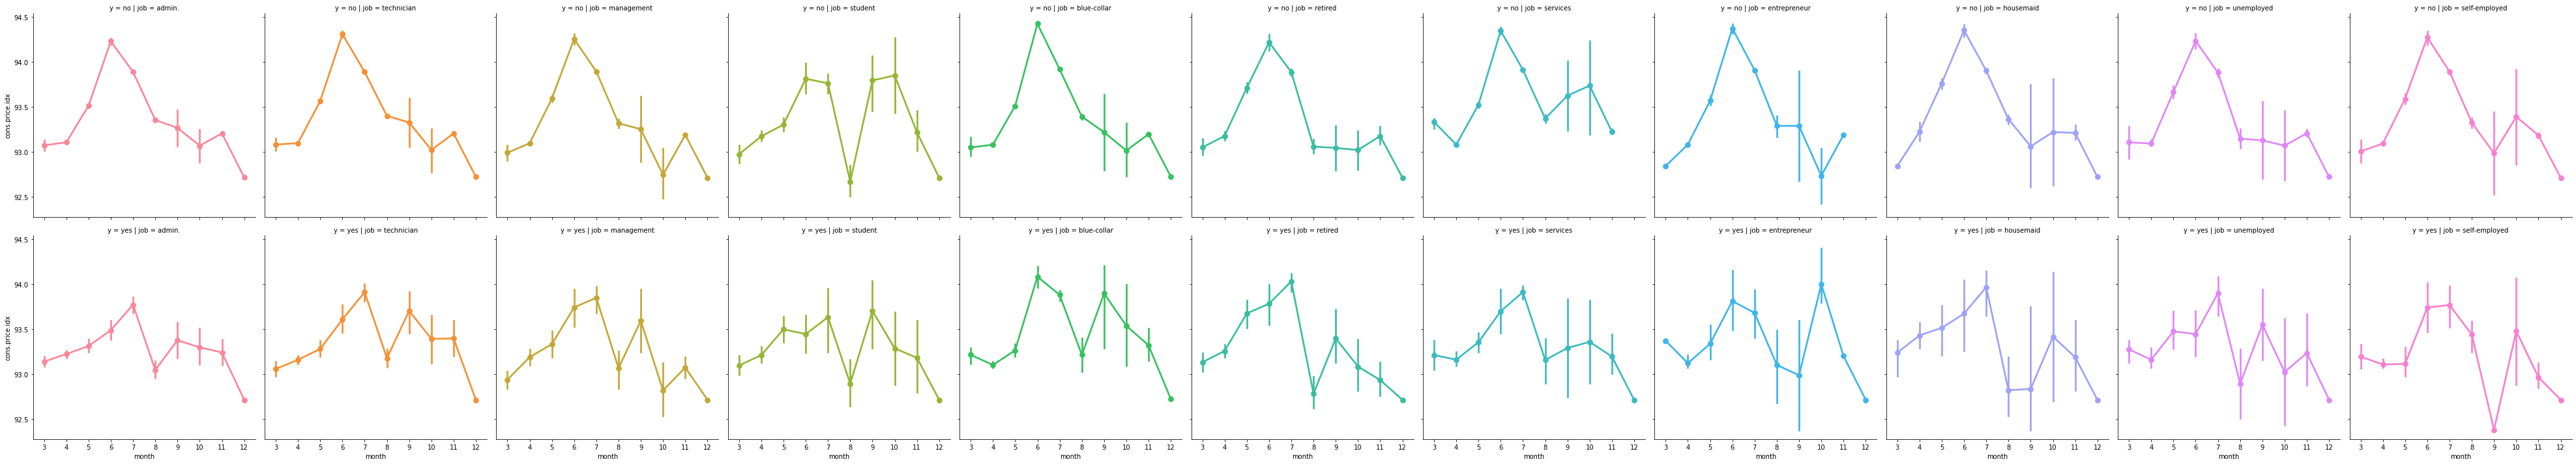

In [56]:
# Plotting the monthly consumer price index for each job group and previous outcome
sns.catplot(x='month', y='cons.price.idx', data=df, kind='point',
            col='job', row='y', hue='job')

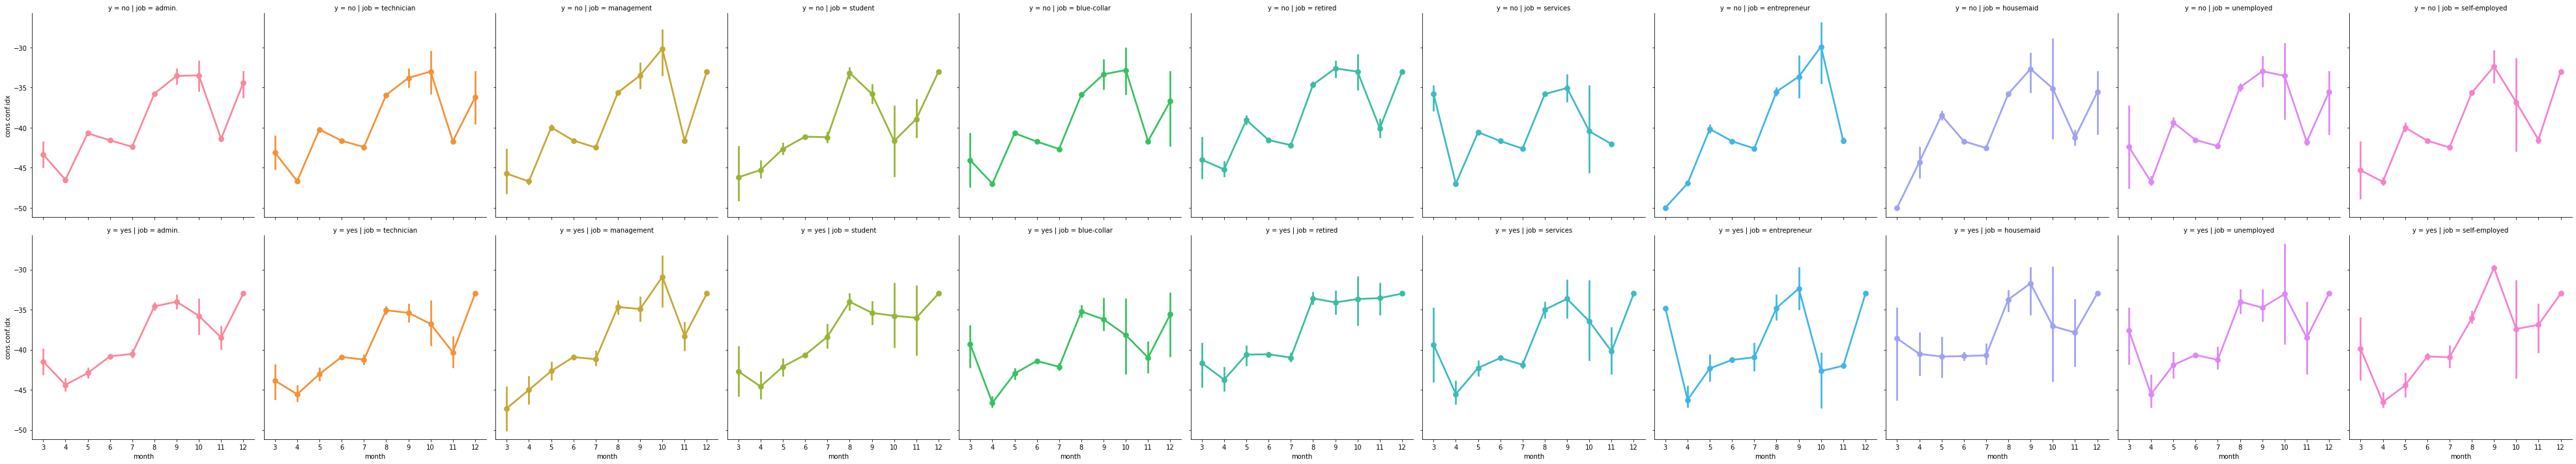

In [57]:
# Plotting the monthly consumer confidence index for each job group and previous outcome
sns.catplot(x='month', y='cons.conf.idx', data=df, kind='point',
            col='job', row='y', hue='job')

<AxesSubplot:xlabel='job'>

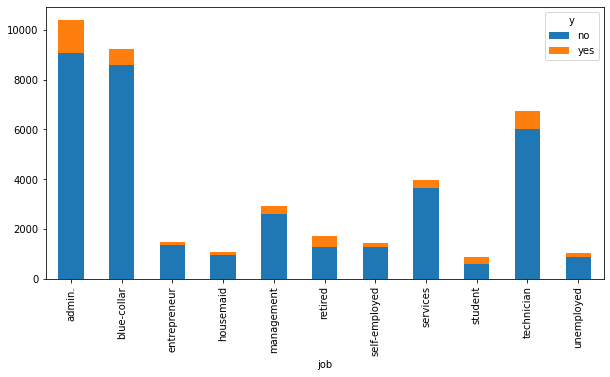

In [36]:
# The target column ditribution across the job groups
dfYJob = df.groupby(['job', 'y']).size().reset_index().pivot(columns='y', index='job', values=0)
dfYJob.plot.bar(stacked=True, figsize=(10,5))

<AxesSubplot:xlabel='education'>

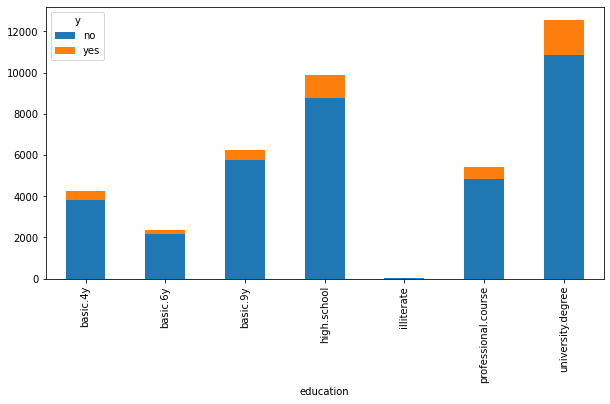

In [37]:
# The target column ditribution across the education groups
dfYJob = df.groupby(['education', 'y']).size().reset_index().pivot(columns='y', index='education', values=0)
dfYJob.plot.bar(stacked=True, figsize=(10,5))

<AxesSubplot:xlabel='marital'>

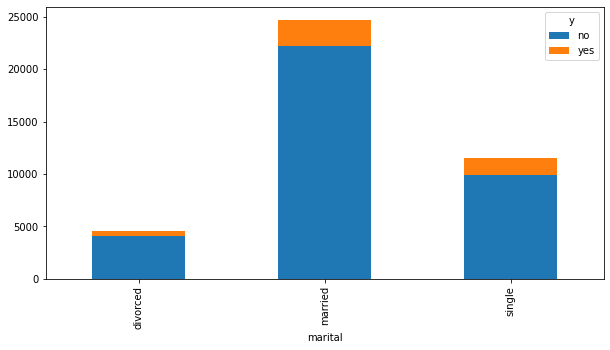

In [46]:
# The target column ditribution across the job groups
dfYJob = df.groupby(['marital', 'y']).size().reset_index().pivot(columns='y', index='marital', values=0)
dfYJob.plot.bar(stacked=True, figsize=(10,5))

<AxesSubplot:xlabel='loan'>

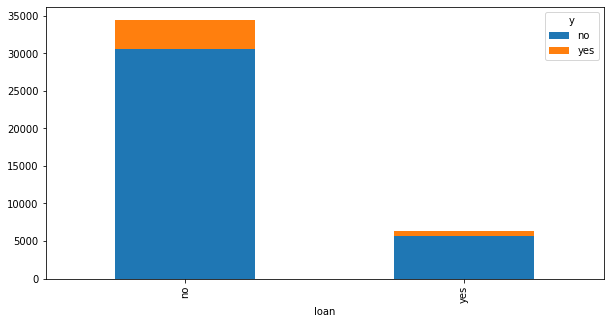

In [47]:
# The target column ditribution across the job groups
dfYJob = df.groupby(['loan', 'y']).size().reset_index().pivot(columns='y', index='loan', values=0)
dfYJob.plot.bar(stacked=True, figsize=(10,5))

<AxesSubplot:xlabel='poutcome'>

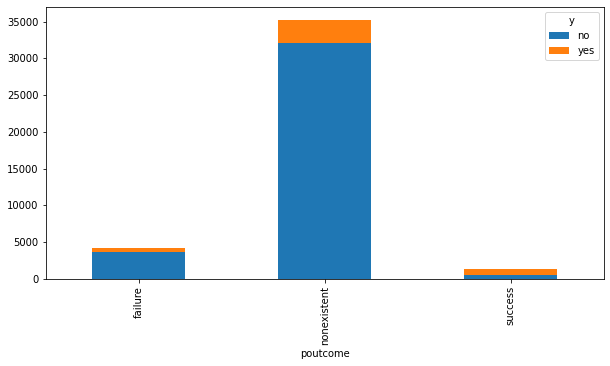

In [49]:
# The target column ditribution across the people with credit in default
dfYJob = df.groupby(['poutcome', 'y']).size().reset_index().pivot(columns='y', index='poutcome', values=0)
dfYJob.plot.bar(stacked=True, figsize=(10,5))

[Text(0, 0, 'housemaid'),
 Text(1, 0, 'services'),
 Text(2, 0, 'admin.'),
 Text(3, 0, 'blue-collar'),
 Text(4, 0, 'technician'),
 Text(5, 0, 'retired'),
 Text(6, 0, 'management'),
 Text(7, 0, 'unemployed'),
 Text(8, 0, 'self-employed'),
 Text(9, 0, 'entrepreneur'),
 Text(10, 0, 'student')]

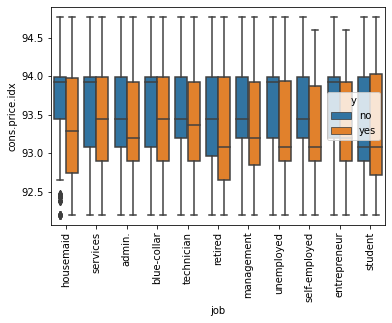

In [28]:
priceChart = sns.boxplot(x="job", y="cons.price.idx", hue='y', data=df)
priceChart.set_xticklabels(priceChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'housemaid'),
 Text(1, 0, 'services'),
 Text(2, 0, 'admin.'),
 Text(3, 0, 'blue-collar'),
 Text(4, 0, 'technician'),
 Text(5, 0, 'retired'),
 Text(6, 0, 'management'),
 Text(7, 0, 'unemployed'),
 Text(8, 0, 'self-employed'),
 Text(9, 0, 'entrepreneur'),
 Text(10, 0, 'student')]

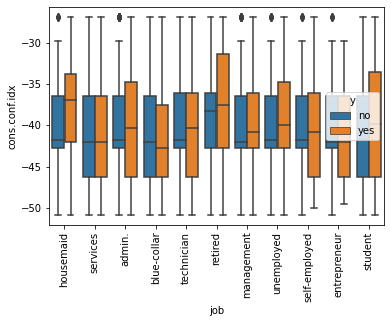

In [27]:
confChart = sns.boxplot(x="job", y="cons.conf.idx", hue='y', data=df)
confChart.set_xticklabels(confChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'housemaid'),
 Text(1, 0, 'services'),
 Text(2, 0, 'admin.'),
 Text(3, 0, 'blue-collar'),
 Text(4, 0, 'technician'),
 Text(5, 0, 'retired'),
 Text(6, 0, 'management'),
 Text(7, 0, 'unemployed'),
 Text(8, 0, 'self-employed'),
 Text(9, 0, 'entrepreneur'),
 Text(10, 0, 'student')]

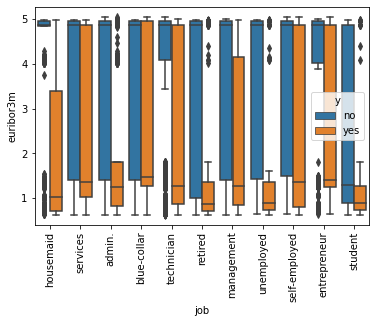

In [26]:
eurChart = sns.boxplot(x="job", y="euribor3m",hue='y', data=df)
eurChart.set_xticklabels(eurChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'housemaid'),
 Text(1, 0, 'services'),
 Text(2, 0, 'admin.'),
 Text(3, 0, 'blue-collar'),
 Text(4, 0, 'technician'),
 Text(5, 0, 'retired'),
 Text(6, 0, 'management'),
 Text(7, 0, 'unemployed'),
 Text(8, 0, 'self-employed'),
 Text(9, 0, 'entrepreneur'),
 Text(10, 0, 'student')]

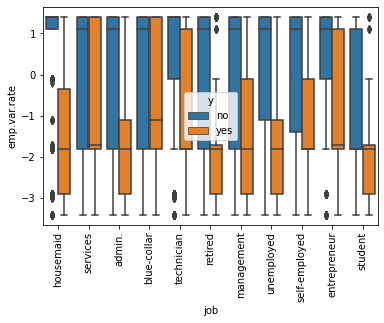

In [25]:
jobEmpChart = sns.boxplot(x="job", y="emp.var.rate",hue='y', data=df)
jobEmpChart.set_xticklabels(jobEmpChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'basic.4y'),
 Text(1, 0, 'high.school'),
 Text(2, 0, 'basic.6y'),
 Text(3, 0, 'basic.9y'),
 Text(4, 0, 'professional.course'),
 Text(5, 0, 'university.degree'),
 Text(6, 0, 'illiterate')]

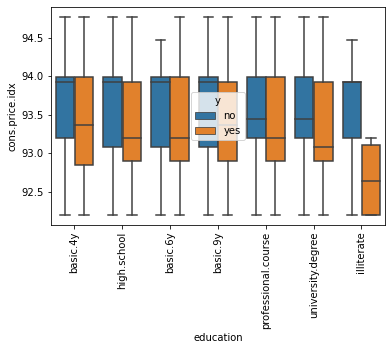

In [24]:
eduPriceChart = sns.boxplot(x="education", y="cons.price.idx", hue='y', data=df)
eduPriceChart.set_xticklabels(eduPriceChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'basic.4y'),
 Text(1, 0, 'high.school'),
 Text(2, 0, 'basic.6y'),
 Text(3, 0, 'basic.9y'),
 Text(4, 0, 'professional.course'),
 Text(5, 0, 'university.degree'),
 Text(6, 0, 'illiterate')]

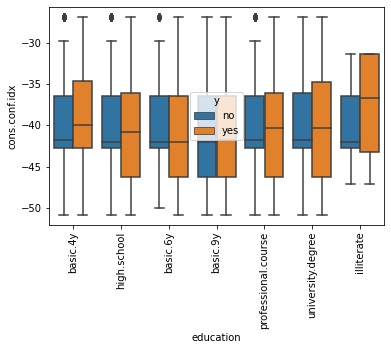

In [23]:
eduConfChart = sns.boxplot(x="education", y="cons.conf.idx", hue='y', data=df)
eduConfChart.set_xticklabels(eduConfChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'basic.4y'),
 Text(1, 0, 'high.school'),
 Text(2, 0, 'basic.6y'),
 Text(3, 0, 'basic.9y'),
 Text(4, 0, 'professional.course'),
 Text(5, 0, 'university.degree'),
 Text(6, 0, 'illiterate')]

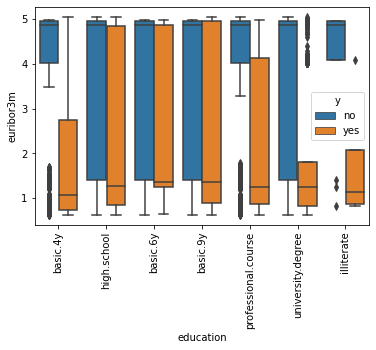

In [22]:
eduEurChart = sns.boxplot(x="education", y="euribor3m", hue='y', data=df)
eduEurChart.set_xticklabels(eduEurChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'basic.4y'),
 Text(1, 0, 'high.school'),
 Text(2, 0, 'basic.6y'),
 Text(3, 0, 'basic.9y'),
 Text(4, 0, 'professional.course'),
 Text(5, 0, 'university.degree'),
 Text(6, 0, 'illiterate')]

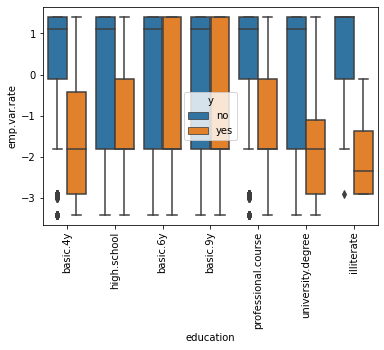

In [21]:
eduEmpChart = sns.boxplot(x="education", y="emp.var.rate", hue='y', data=df)
eduEmpChart.set_xticklabels(eduEmpChart.get_xticklabels(), rotation=90)

[Text(0, 0, 'basic.4y'),
 Text(1, 0, 'high.school'),
 Text(2, 0, 'basic.6y'),
 Text(3, 0, 'basic.9y'),
 Text(4, 0, 'professional.course'),
 Text(5, 0, 'university.degree'),
 Text(6, 0, 'illiterate')]

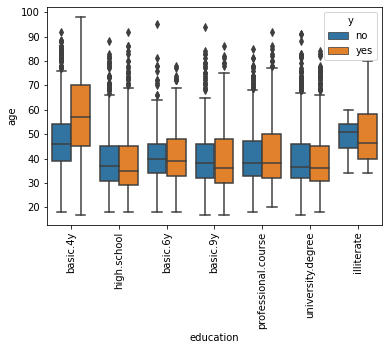

In [20]:
eduAgeChart = sns.boxplot(x="education", y="age", hue='y', data=df)
eduAgeChart.set_xticklabels(eduAgeChart.get_xticklabels(), rotation=90)

<AxesSubplot:xlabel='y', ylabel='count'>

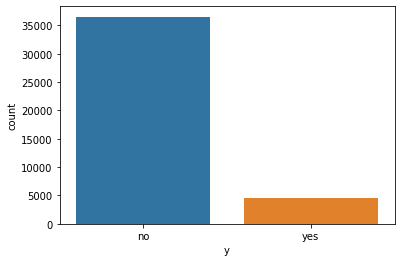

In [160]:
sns.countplot(df.y)

### Confusion matrix

<AxesSubplot:>

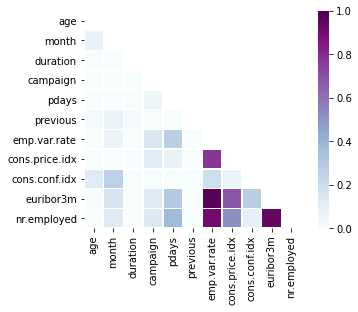

In [58]:
# get the correlation matrix
corr = df.corr()

# create a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the correlation heatmap
sns.heatmap(corr, vmin=0, vmax=1, square=True, cmap="BuPu",
           linewidths=.5, mask=mask, fmt='.2f')

### Preprocessing

In [31]:
dfPrep = pd.read_csv('../bank-additional-full.csv', delimiter=';')

In [32]:
dfPrep.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [33]:
class preprocess():
    def __init__(self):
        pass
    
    # This function turns object columns to categorical columns
    def toCat(self, df):
        colList = list(df.select_dtypes(include='object'))
        for col in colList:
            df[col] = df[col].astype('category')
        
        return df
    
    # transforms categorical columns to a one hot vector/ array
    def oneHot(self, df):
        colList = list(df.select_dtypes(include='category'))
        prefList = []

        # create a prefix on how to name the new dummy columns
        for col in colList:
            prefList.append("is_" + col)

        df = pd.get_dummies(df, columns=colList, prefix=prefList)
        return df
    
    # uses the StandardScaler to normalize our data
    def scalerDf(self, df, rmColList):
        # get all the numerical columns minus the ones in rmColList
        colList = list(dfPrep.select_dtypes(include=['int64', 'float64']))
        colList = [i for i in colList if i not in rmColList]
        
        scaler = StandardScaler()
        scaled = scaler.fit(df[colList].values)
        df[colList] = scaled.transform(df[colList].values)
        return df

In [34]:
pre = preprocess()
dfPrep = pre.toCat(dfPrep)

In [35]:
# separate the target column from the feature columns
y = dfPrep['y']
dfPrep = dfPrep.drop(['y', 'duration'], axis=1)

# transform value in the categorical columns from above to a one hot vector
dfPrep = pre.oneHot(dfPrep)
dfPrep.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,is_job_admin.,...,is_month_oct,is_month_sep,is_day_of_week_fri,is_day_of_week_mon,is_day_of_week_thu,is_day_of_week_tue,is_day_of_week_wed,is_poutcome_failure,is_poutcome_nonexistent,is_poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,...,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0


In [36]:
dfPrep.dtypes

age                          int64
campaign                     int64
pdays                        int64
previous                     int64
emp.var.rate               float64
                            ...   
is_day_of_week_tue           uint8
is_day_of_week_wed           uint8
is_poutcome_failure          uint8
is_poutcome_nonexistent      uint8
is_poutcome_success          uint8
Length: 62, dtype: object

In [37]:
labelEnc = LabelEncoder()
y = labelEnc.fit_transform(y)

In [38]:
# specify the columns you wish to not perform standardization on.
rmList = ['campaign', 'previous']

# Use Standard scaler on the columns from above
dfPrep = pre.scalerDf(dfPrep, rmList)

In [39]:
dfPrep.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,is_job_admin.,...,is_month_oct,is_month_sep,is_day_of_week_fri,is_day_of_week_mon,is_day_of_week_thu,is_day_of_week_tue,is_day_of_week_wed,is_poutcome_failure,is_poutcome_nonexistent,is_poutcome_success
0,1.533034,1,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0
1,1.628993,1,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0
2,-0.290186,1,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.002309,1,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,1,...,0,0,0,1,0,0,0,0,1,0
4,1.533034,1,0.195414,0,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
y.shape

(41188,)

### SMOTE

From the Data Analysis section we can see there is a class imbalance in the Y column i.e No >>> Yes to correct this we use a techinque called oversampling where we over sample the minority class.

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [65]:
# Carry out Smote on the dataset
smote = SMOTE(sampling_strategy='minority')
xSm, ySm = smote.fit_sample(dfPrep, y) 

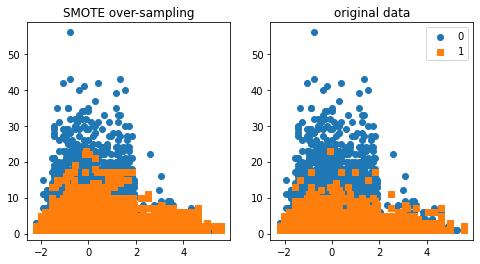

In [60]:
def plot2dSpace(X_train, y_train,X,y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train.iloc[y_train==l, 0],
            X_train.iloc[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X.iloc[y==l, 0],
            X.iloc[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()
    
plot2dSpace(xSm, ySm, dfPrep, y, 'SMOTE over-sampling')

However, oversampling (SMOTE) should only be applied after splitting the data into folds. Applying SMOTE before splitting leaks data (the oversampled portion) to the train sets and therefore, overfitting the validation sets, resulting to a high but inaccurate AUC.

### T-Distributed Stochastic Neighbouring Entities (TSNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets.The original paper describes the working of t-SNE as:

> t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

Essentially what this means is that it looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions

In [12]:
# defining TSNE and fitting it into our data
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsneResults = tsne.fit_transform(dfPrep)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 41188 samples in 4.213s...
[t-SNE] Computed neighbors for 41188 samples in 344.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41188
[t-SNE] Computed conditional probabilities for sample 2000 / 41188
[t-SNE] Computed conditional probabilities for sample 3000 / 41188
[t-SNE] Computed conditional probabilities for sample 4000 / 41188
[t-SNE] Computed conditional probabilities for sample 5000 / 41188
[t-SNE] Computed conditional probabilities for sample 6000 / 41188
[t-SNE] Computed conditional probabilities for sample 7000 / 41188
[t-SNE] Computed conditional probabilities for sample 8000 / 41188
[t-SNE] Computed conditional probabilities for sample 9000 / 41188
[t-SNE] Computed conditional probabilities for sample 10000 / 41188
[t-SNE] Computed conditional probabilities for sample 11000 / 41188
[t-SNE] Computed conditional probabilities for sample 12000 / 41188
[t-SNE] Computed conditional probabilities for 

Now that we have the two resulting dimensions we can again visualise them by creating a scatter plot of the two dimensions and coloring each sample by its respective label.

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

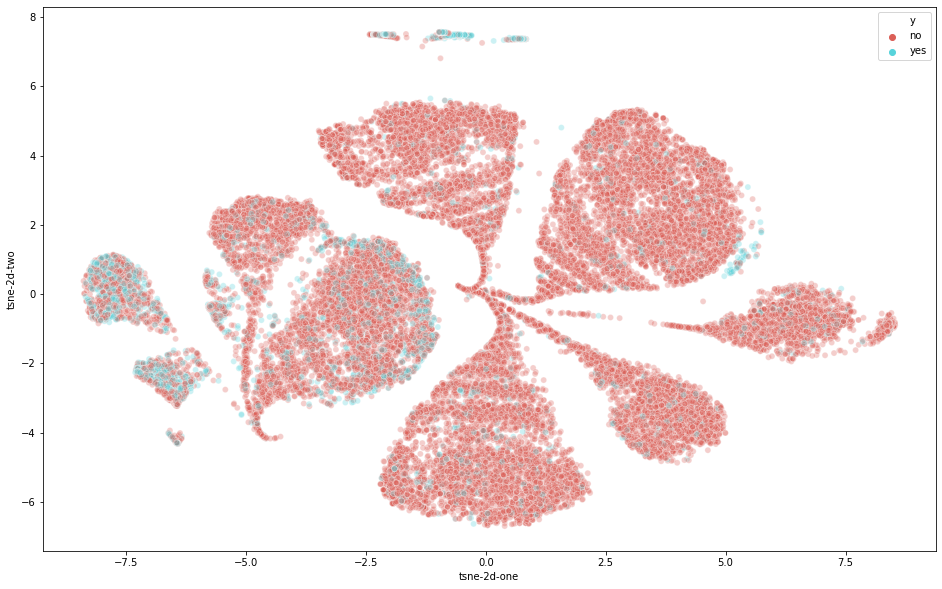

In [13]:
# visualizing the dimension reduction of TSNE
# copy the dataset to avoid messing with the values in the actual dataset
dfTsne = dfPrep.copy()
dfTsne['y'] = y
dfTsne['tsne-2d-one'] = tsneResults[:,0]
dfTsne['tsne-2d-two'] = tsneResults[:,1]

# plotting the results from TSNE in 2D
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=dfTsne,
    legend="full",
    alpha=0.3
)

### PCA

PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed.

In [14]:
# defining PCA and fitting it into our data
pca = PCA(n_components=2)
pcaResult = pca.fit_transform(dfPrep)

In [19]:
# copy the dataset to avoid messing with the values in the actual dataset
dfPca = dfPrep.copy()
dfPca['y'] = y
dfPca['pca-one'] = pcaResult[:,0]
dfPca['pca-two'] = pcaResult[:,1] 

# Showing the explained variance for each ratio
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.38140907 0.1787821 ]


 We are able to explain around 55% variance in the dataset using just two components

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

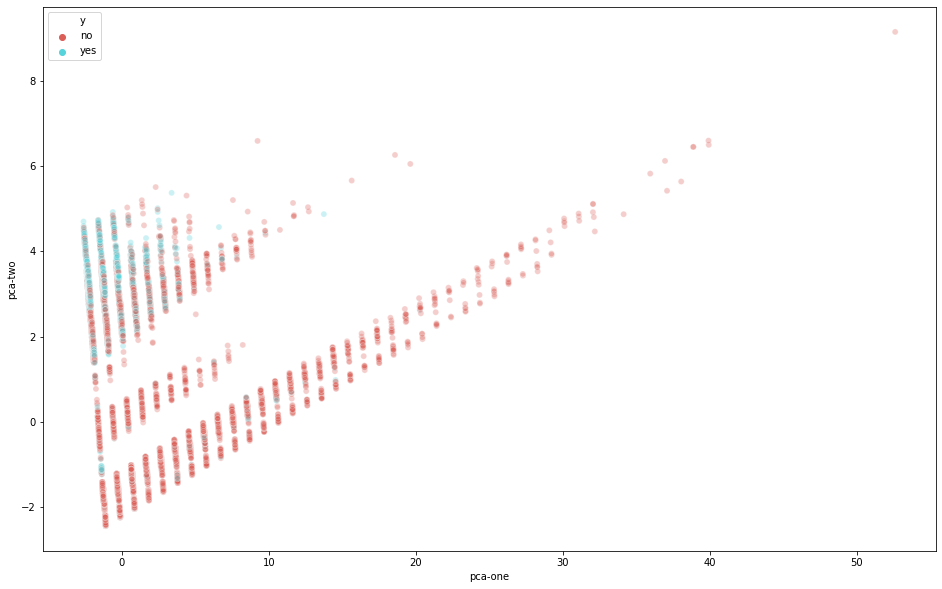

In [21]:
# plotting the results from PCA 
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=dfPca,
    legend="full",
    alpha=0.3
)

The first component contains information mainly for y=no while the second component has information about both values of Y 

### Machine Learning Model

In [13]:
# defining the logging formt
form = logging.Formatter("%(asctime)s : %(levelname)-5.5s : %(message)s")
logger = logging.getLogger()

# setting the logging format
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(form)
logger.addHandler(consoleHandler)

# set the logger level
logger.setLevel(logging.DEBUG)

class modelPlusFold:
    def __init__(self):
        pass
    
    def modelKfold(self, model, x, y):
        logger.info("\n running KFold on {}".format(model))
        # A list to append all the score for each fold
        rocScores = []
        f1Scores = []

        # split the data further using KFold
        cv = KFold(n_splits=5,random_state=42, shuffle=True)
        for trainIndex, testIndex in cv.split(x):

            cvXTrain, cvXTest = x[trainIndex], x[testIndex]
            cvYTrain, cvYTest = y[trainIndex], y[testIndex]

            # Carry out Smote on the split data
            smote = SMOTE(sampling_strategy='minority')
            xSm, ySm = smote.fit_sample(cvXTrain, cvYTrain)

            # Train the model and predict on the test set
            modelTrained = model.fit(xSm, ySm)
            yPred = modelTrained.predict(cvXTest)

            # find the score (score for one fold) and append them to the scores list(all the scores)
            rocScores.append(round(roc_auc_score(cvYTest, yPred), 2))
            f1Scores.append(round(f1_score(cvYTest, yPred), 2))

        # Calculate the average roc and f1 scores of the folds
        avgRoc = mean(rocScores)
        avgF1 = mean(f1Scores)
        
        return modelTrained, avgRoc, avgF1

    def modelStratifiedFold(self, model, x, y):
        logger.info("\n running StratifiedKFold on {} \n".format(model))
        rocScores = []
        f1Scores = []

        # split the data further using StratifiedKFold
        cv = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
        for trainIndex, testIndex in cv.split(x, y):

            cvXTrain, cvXTest = x[trainIndex], x[testIndex]
            cvYTrain, cvYTest = y[trainIndex], y[testIndex]
            
            # Carry out Smote on the split data
            smote = SMOTE(sampling_strategy='minority')
            xSm, ySm = smote.fit_sample(cvXTrain, cvYTrain)
            
            # Train the model and predict on the test set
            modelTrained = model.fit(xSm, ySm)
            yPred = modelTrained.predict(cvXTest)

            # find the score (score for one fold) and append them to the scores list(all the scores)
            rocScores.append(round(roc_auc_score(cvYTest, yPred), 2))
            f1Scores.append(round(f1_score(cvYTest, yPred), 2))

        # Calculate the average roc and f1 scores of the folds
        avgRoc = mean(rocScores)
        avgF1 = mean(f1Scores)
        
        return modelTrained, avgRoc, avgF1
    

### Model with Outliers

In [14]:
# split the train data into a training and test set
xTrain, xTest, yTrain, yTest = train_test_split(tsneResults, y, random_state=42, test_size=0.1)

logReg = LogisticRegression()
mlp = MLPClassifier()
xGradient = xgb.XGBClassifier()
decisionTree = DecisionTreeClassifier()

plusFold = modelPlusFold()

# training the models using KFold
logRegKTrained, lrKRoc, lrKF1 = plusFold.modelKfold(logReg, xTrain, yTrain)
mlpKTrained, mlKRoc, mlKF1 = plusFold.modelKfold(mlp, xTrain, yTrain)
xGradientKTrained, xgKRoc, xgKF1 = plusFold.modelKfold(xGradient, xTrain, yTrain)
decisionTreeKTrained, dtKRoc, dtKF1 = plusFold.modelKfold(decisionTree, xTrain , yTrain)

# training the models using StratifiedFold
logRegStratTrained, lrStratRoc, lrStratF1 = plusFold.modelStratifiedFold(logReg, xTrain, yTrain)
mlpStratTrained, mlStratRoc, mlStratF1 = plusFold.modelStratifiedFold(mlp, xTrain , yTrain)
xGradientStratTrained, xgStratRoc, xgStratF1 = plusFold.modelStratifiedFold(xGradient, xTrain, yTrain)
decisionTreeStratTrained, dtStratRoc, dtStratF1 = plusFold.modelStratifiedFold(decisionTree, xTrain , yTrain)


2020-08-29 09:07:15,171 : INFO  : 
 running KFold on LogisticRegression()
2020-08-29 09:07:17,731 : INFO  : 
 running KFold on MLPClassifier()
2020-08-29 09:12:46,054 : INFO  : 
 running KFold on XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
2020-08-29 09:13:13,439 : INFO  : 
 running KFold on DecisionTreeClassifier()
2020-08-29 09:13:22,203 : INFO  : 
 running StratifiedKFold on LogisticRegression() 

2020-08-

In [15]:
models = [logReg, mlp, xGradient, decisionTree]
kFoldRoc = [lrKRoc, mlKRoc, xgKRoc, dtKRoc]
kFoldF1 = [lrKF1, mlKF1, xgKF1, dtKF1]
stratRoc = [lrStratRoc, mlStratRoc, xgStratRoc, dtStratRoc]
stratF1 = [lrStratF1, mlStratF1, xgStratF1, dtStratF1]

def printScores(models, kFoldRoc, kFoldF1, stratRoc, stratF1):
    all = zip(models, kFoldRoc, kFoldF1, stratRoc, stratF1)
    
    for model,kroc, kf1, sroc, sf1 in all:    
        print('\n The score for {} are: '.format(model))
        print('KFold Score: roc_auc_score {} f1_score {} \n StratifiedScore: roc_auc_score {} f1_score {} \n'
              .format(kroc, kf1, sroc, sf1))

printScores(models, kFoldRoc, kFoldF1, stratRoc, stratF1)


 The score for LogisticRegression() are: 
KFold Score: roc_auc_score 0.646 f1_score 0.288 
 StratifiedScore: roc_auc_score 0.644 f1_score 0.288 


 The score for MLPClassifier() are: 
KFold Score: roc_auc_score 0.744 f1_score 0.456 
 StratifiedScore: roc_auc_score 0.74 f1_score 0.444 


 The score for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) are: 
KFold Score: roc_auc_score 0.726 f1_score 0.426 
 StratifiedScore: roc_auc_score 0.722 f1_score 0.42 


 The

### Model without outliers

In [17]:
# Use Isolation Forest to identify outliers in the data
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(xTrain)

# select all rows that are not outliers
mask = yhat != -1
xTrainI, yTrainI = xTrain[mask, :], yTrain[mask]

# training the models using KFold
logRegKTrainedI, lrKRocI, lrKF1I = plusFold.modelKfold(logReg, xTrainI, yTrainI)
mlpKTrainedI, mlKRocI, mlKF1I = plusFold.modelKfold(mlp, xTrainI, yTrainI)
xGradientKTrainedI, xgKRocI, xgKF1I = plusFold.modelKfold(xGradient, xTrainI, yTrainI)
decisionTreeKTrainedI, dtKRocI, dtKFI1 = plusFold.modelKfold(decisionTree, xTrainI , yTrainI)

# training the models using StratifiedFold
logRegStratTrainedI, lrStratRocI, lrStratF1I = plusFold.modelStratifiedFold(logReg, xTrainI, yTrainI)
mlpStratTrainedI, mlStratRocI, mlStratF1I = plusFold.modelStratifiedFold(mlp, xTrainI , yTrainI)
xGradientStratTrainedI, xgStratRocI, xgStratF1I = plusFold.modelStratifiedFold(xGradient, xTrainI, yTrainI)
decisionTreeStratTrainedI, dtStratRocI, dtStratF1I = plusFold.modelStratifiedFold(decisionTree, xTrainI , yTrainI)

2020-08-29 09:21:54,326 : INFO  : 
 running KFold on LogisticRegression()
2020-08-29 09:21:56,301 : INFO  : 
 running KFold on MLPClassifier()
2020-08-29 09:28:13,879 : INFO  : 
 running KFold on XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
2020-08-29 09:28:29,834 : INFO  : 
 running KFold on DecisionTreeClassifier()
2020-08-29 09:28:34,327 : INFO  : 
 running StratifiedKFold on LogisticRegression() 

2020-08-29 09:28:36,293 : INFO  : 
 running StratifiedKFol

In [22]:
models = [logReg, mlp, xGradient, decisionTree]
kFoldRocI = [lrKRocI, mlKRocI, xgKRocI, dtKRocI]
kFoldF1I = [lrKF1I, mlKF1I, xgKF1I, dtKFI1]
stratRocI = [lrStratRocI, mlStratRocI, xgStratRocI, dtStratRocI]
stratF1I = [lrStratF1I, mlStratF1I, xgStratF1I, dtStratF1I]

printScores(models, kFoldRocI, kFoldF1I, stratRocI, stratF1I)


 The score for LogisticRegression() are: 
KFold Score: roc_auc_score 0.67 f1_score 0.274 
 StratifiedScore: roc_auc_score 0.668 f1_score 0.274 


 The score for MLPClassifier() are: 
KFold Score: roc_auc_score 0.692 f1_score 0.324 
 StratifiedScore: roc_auc_score 0.694 f1_score 0.34 


 The score for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) are: 
KFold Score: roc_auc_score 0.676 f1_score 0.316 
 StratifiedScore: roc_auc_score 0.678 f1_score 0.318 


 The

The Multilayer perceptron model performs best in the two scenario with outliers and without outliers, with the former performing better, this may be due to the normalization and dimension reduction carried out before the removal of outliers
The Stratified version performed better KFold method so we use this model for the validation set 

### Validation Set

In [23]:
# predict on the validation set
yPred = mlpStratTrained.predict(xTest)
confusionMatrix = confusion_matrix(yTest, yPred)
confusionMatrix

array([[3085,  572],
       [ 260,  202]])

**Intepretating Confusion Matrix**


|  | Predicted: No | Predicted Yes |
| --- | --- | --- |
| Actual No |TN: 3085  | FP: 572 |
|  |  |  |
| Actual Yes |FN: 260  | TP: 202 |

1. Correct predictions: 3085 + 202 = 3287

2. Wrong Predictions: 260+ 572 = 832
  

In [24]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      3657
           1       0.26      0.44      0.33       462

    accuracy                           0.80      4119
   macro avg       0.59      0.64      0.60      4119
weighted avg       0.85      0.80      0.82      4119



2020-08-29 09:51:52,825 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2020-08-29 09:51:52,831 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
2020-08-29 09:51:52,833 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-29 09:51:52,837 : DEBUG : findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:52,844 : DEBUG : findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:52,848 : DEBUG : findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:52,852 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
2020-08-29 09:51:52,857 : DEBUG : findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:52,862 : D

2020-08-29 09:51:53,327 : DEBUG : findfont: score(<Font 'MathJax_Fraktur' (MathJax_Fraktur-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:53,330 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:53,335 : DEBUG : findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Bold.otf) normal normal 700 normal>) = 10.335
2020-08-29 09:51:53,347 : DEBUG : findfont: score(<Font 'MathJax_Script' (MathJax_Script-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:53,357 : DEBUG : findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Bold.otf) normal normal 700 normal>) = 10.335
2020-08-29 09:51:53,368 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:53,373 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
2020-08-29 09:51:53,382 : DEBUG : findfont

2020-08-29 09:51:54,402 : DEBUG : findfont: score(<Font 'MathJax_Vector' (MathJax_Vector-Regular.otf) normal normal 500 normal>) = 10.145
2020-08-29 09:51:54,409 : DEBUG : findfont: score(<Font 'MathJax_Size2' (MathJax_Size2-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:54,419 : DEBUG : findfont: score(<Font 'MathJax_Vector-Bold' (MathJax_Vector-Bold.otf) normal normal 500 normal>) = 10.145
2020-08-29 09:51:54,445 : DEBUG : findfont: score(<Font 'MathJax_Main' (MathJax_Main-Italic.otf) italic normal 400 normal>) = 11.05
2020-08-29 09:51:54,452 : DEBUG : findfont: score(<Font 'MathJax_Math' (MathJax_Math-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:54,464 : DEBUG : findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:54,481 : DEBUG : findfont: score(<Font 'MathJax_Main' (MathJax_Main-Regular.otf) normal normal 400 normal>) = 10.05
2020-08-29 09:51:54,497 : DEBUG : findfont: sc

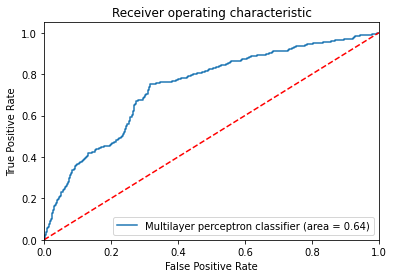

In [25]:

mlpRoc = roc_auc_score(yTest, yPred)
fpr, tpr, thresholds = roc_curve(yTest, mlpStratTrained.predict_proba(xTest)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Multilayer perceptron classifier (area = %0.2f)' % mlpRoc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('MLP_ROC')
plt.show()

### Comparison

Let's compare our model above and a model where Oversampling and Cross Validation was not carried out. We will compare the precision recall and f1-score for the two models

In [28]:
modelMlp = mlp.fit(xTrain, yTrain)

# predict on the validation set
yPred = modelMlp.predict(xTest)
confusionMatrix = confusion_matrix(yTest, yPred)
confusionMatrix

array([[3621,   36],
       [ 375,   87]])

In [29]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3657
           1       0.71      0.19      0.30       462

    accuracy                           0.90      4119
   macro avg       0.81      0.59      0.62      4119
weighted avg       0.88      0.90      0.87      4119



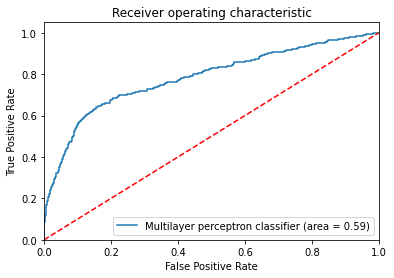

In [30]:
mlpRoc = roc_auc_score(yTest, yPred)
fpr, tpr, thresholds = roc_curve(yTest, mlpStratTrained.predict_proba(xTest)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Multilayer perceptron classifier (area = %0.2f)' % mlpRoc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('MLP_ROC')
plt.show()

As we can see the Model where oversampling and cross-validation has been done performs better, These techniques are therefore necessary in data with imbalanced classes to build robust and accurate models  